# Ciclope tetra uFE pipeline @ JCW_2022
from CT image to tetrahedra-FE model solution in Calculix

Created on:  23.05.2021 <br />
Last update: 10.06.2022 <br />

- Data source: LHDL project (IOR Bologna, Italy)
- More info on the dataset source [here](http://projects.kmi.open.ac.uk/lhdl/)
- For info on the solver visit the [Calculix homepage](http://www.calculix.de/)

---
The pipeline can be executed from the command line using the **ciclope** command: <br />
```commandline
python ciclope.py test_data/LHDL/3155_D_4_bc/cropped/3155_D_4_bc_0000.tif test_data/LHDL/3155_D_4_bc/3155_D_4_bc.inp -vs 0.0195 0.0195 0.0195 -r 2 -t 63 --tetrafe --vol_mesh --template input_templates/tmp_example01_comp_static_bone.inp --verbose
```

Type `python ciclope.py -h` to display the ciclope help with detailed information on command line arguments.

![FE pipeline](fem_pipeline.png)

## Configuration

In [1]:
import sys
sys.path.append('./../../')

In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import mcubes
from scipy import ndimage, misc
from skimage.filters import threshold_otsu, gaussian
from skimage import measure, morphology

from recon_utils import read_tiff_stack, plot_midplanes
import ciclope

matplotlib.rcParams['figure.dpi'] = 300

font = {'weight' : 'normal',
        'size'   : 8}

plt.rc('font', **font)

astropy module not found
olefile module not found


#### Load input data

In [3]:
input_file = './../../test_data/LHDL/3155_D_4_bc/cropped/3155_D_4_bc_0000.tif'

Input data description

|Scan parameters|   |
|:-|:-|
|Lab|LTM@IOR Bologna|
|Sample|Human trabecular bone|
|Energy| |
|Voxel size|19.5 micron|
|Preliminary operations|cropped to 200x200x200 (4mm side)|

Read the input data and define an array of the voxelsize

In [4]:
data_3D = read_tiff_stack(input_file)
vs = np.ones(3)*19.5e-3 # [mm]

Inspect the dataset

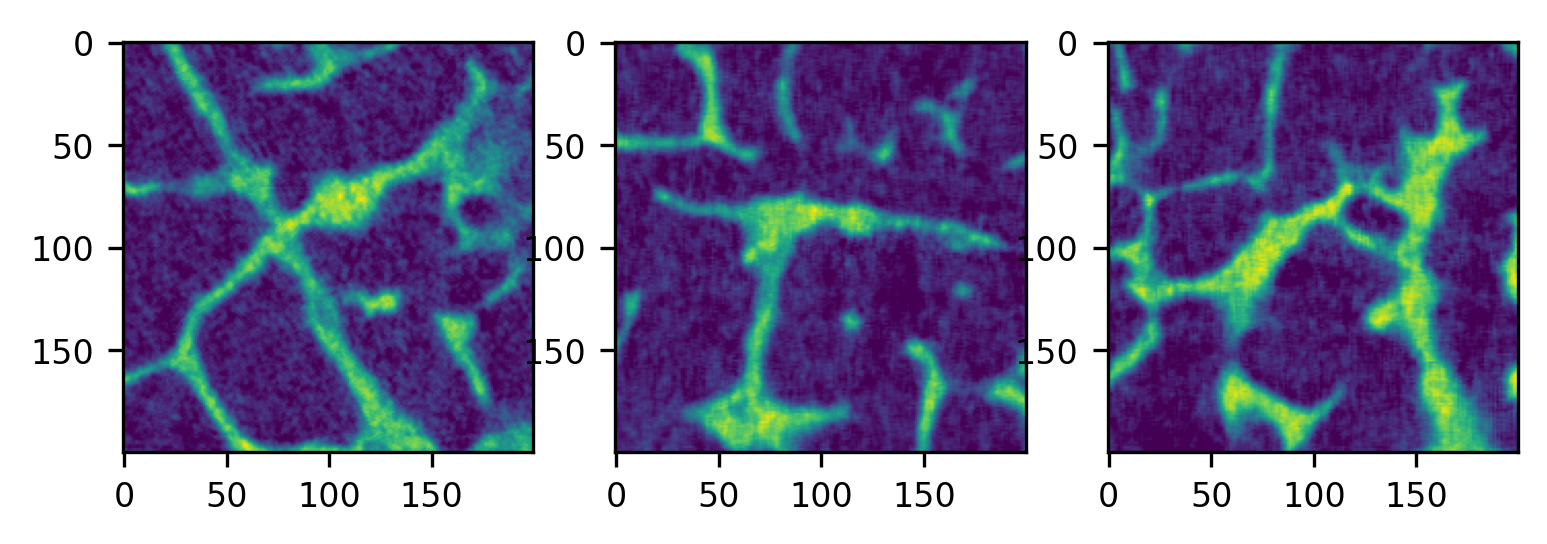

In [5]:
plot_midplanes(data_3D)
plt.show()

Inspect the dataset with [itkwidgets](https://github.com/InsightSoftwareConsortium/itkwidgets)

In [6]:
import itk
from itkwidgets import view
viewer = view(data_3D, ui_collapsed=True)
viewer.interpolation = False

In [ ]:
# launch the itk viewer
viewer

![LHDL rendering](LHDL_sample.png)

## Pre-processing
### Gaussian smooth

In [6]:
data_3D = gaussian(data_3D, sigma=1, preserve_range=True)

### Resize (optional)

In [7]:
resampling = 2

# resize the 3D data using spline interpolation of order 2
data_3D = ndimage.zoom(data_3D, 1/resampling, output=None, order=2)

# correct voxelsize
vs = vs * resampling

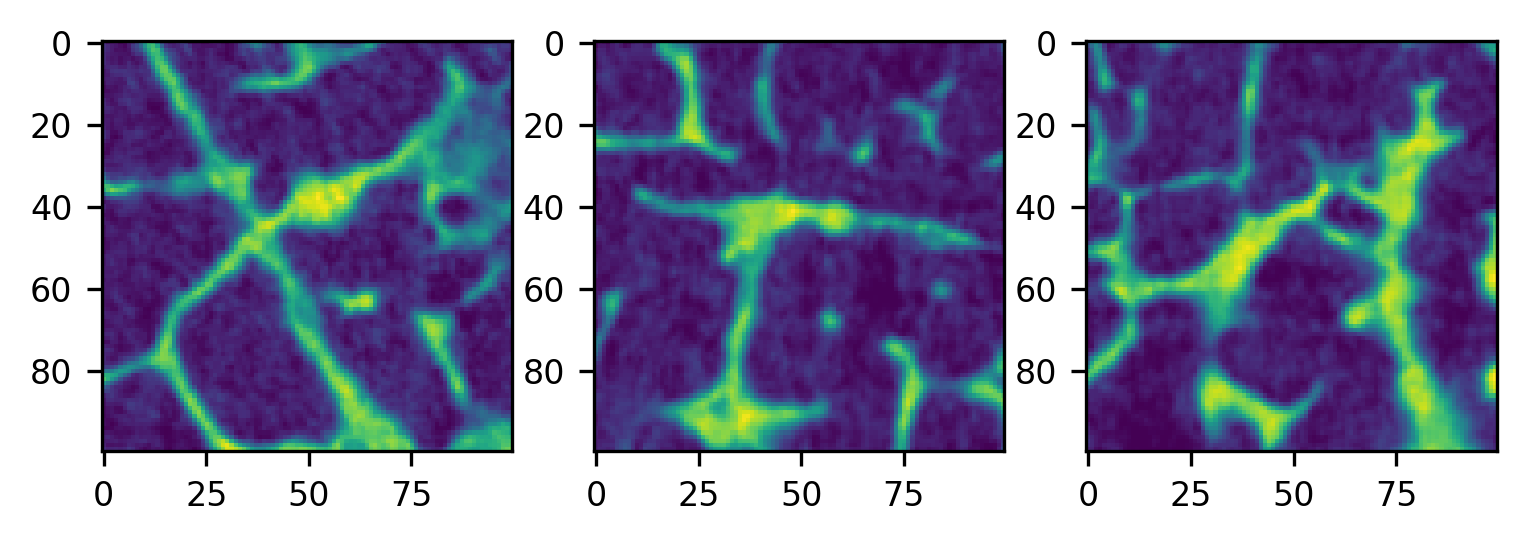

In [8]:
# Inspect again the dataset
plot_midplanes(data_3D)
plt.show()

### Thresholding


In [9]:
# use Otsu's method
T = threshold_otsu(data_3D)
print("Threshold: {}".format(T))

Threshold: 80.92566349845595


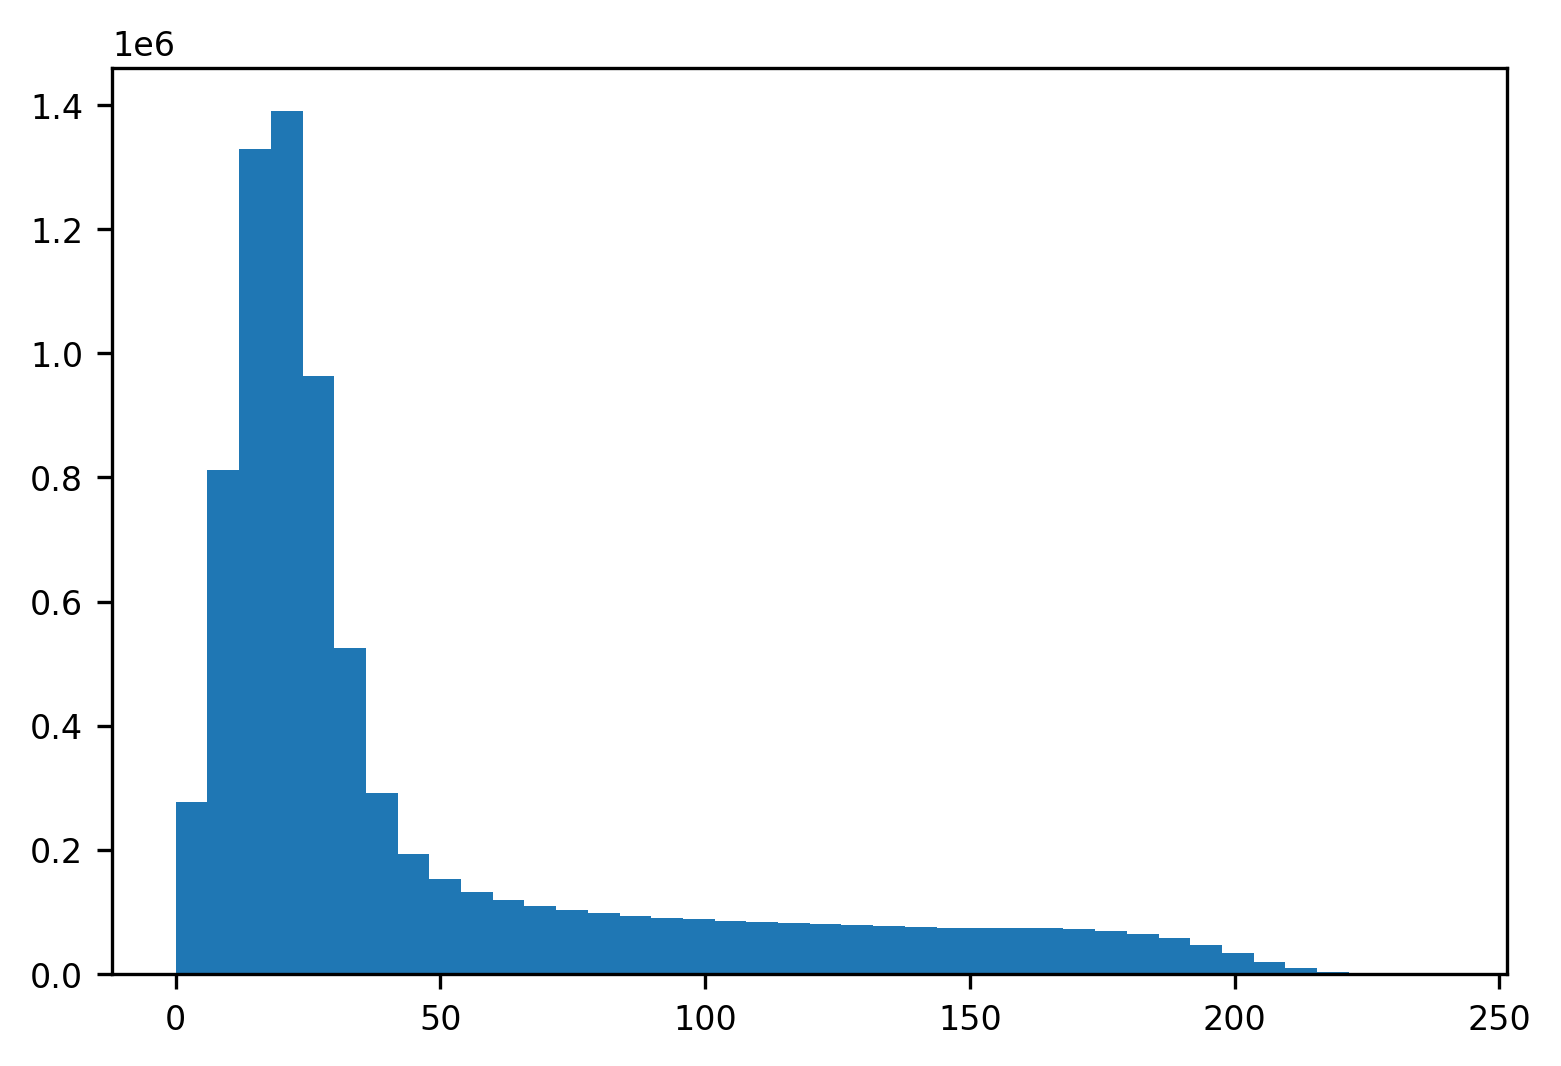

In [10]:
# plot the input image histogram
fig2, ax2 = plt.subplots()
plt.hist(data_3D.ravel(), bins=40)
plt.show()

Apply the threshold

In [10]:
# BW = data_3D > T
BW = data_3D > 63 # from comparison with histology

Have a look at the binarized dataset

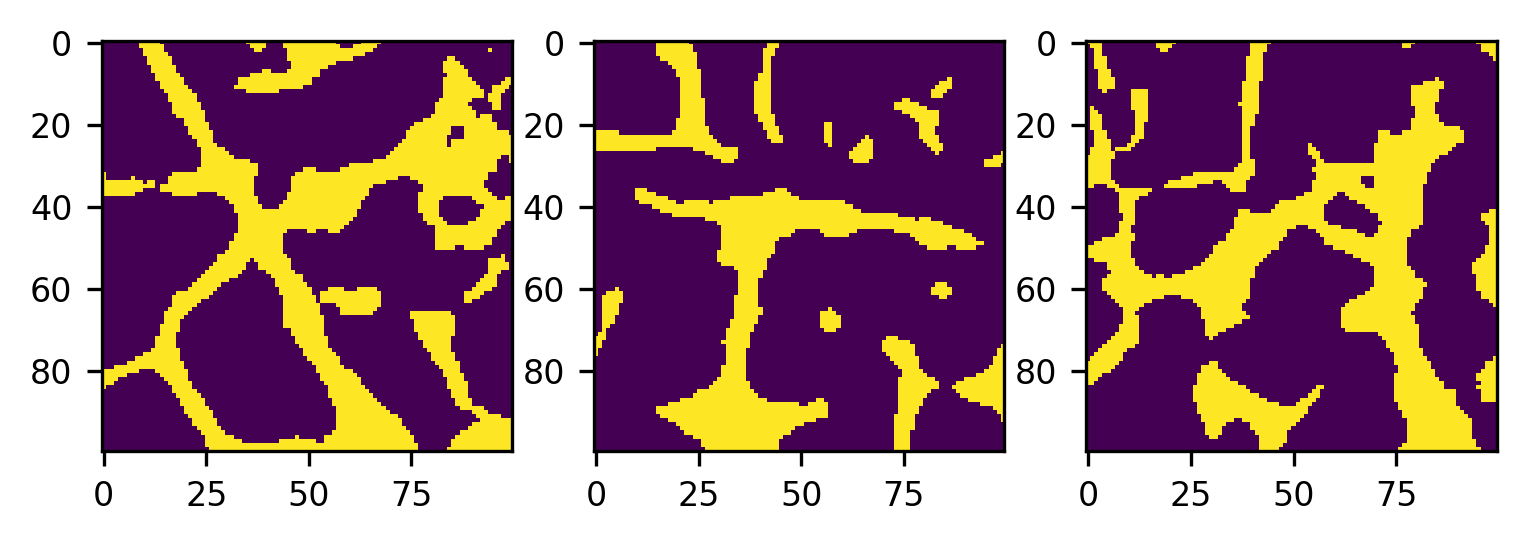

In [11]:
plot_midplanes(BW)
plt.show()

### Morphological close of binary image (optional)

In [12]:
BW = morphology.closing(BW, morphology.ball(3))

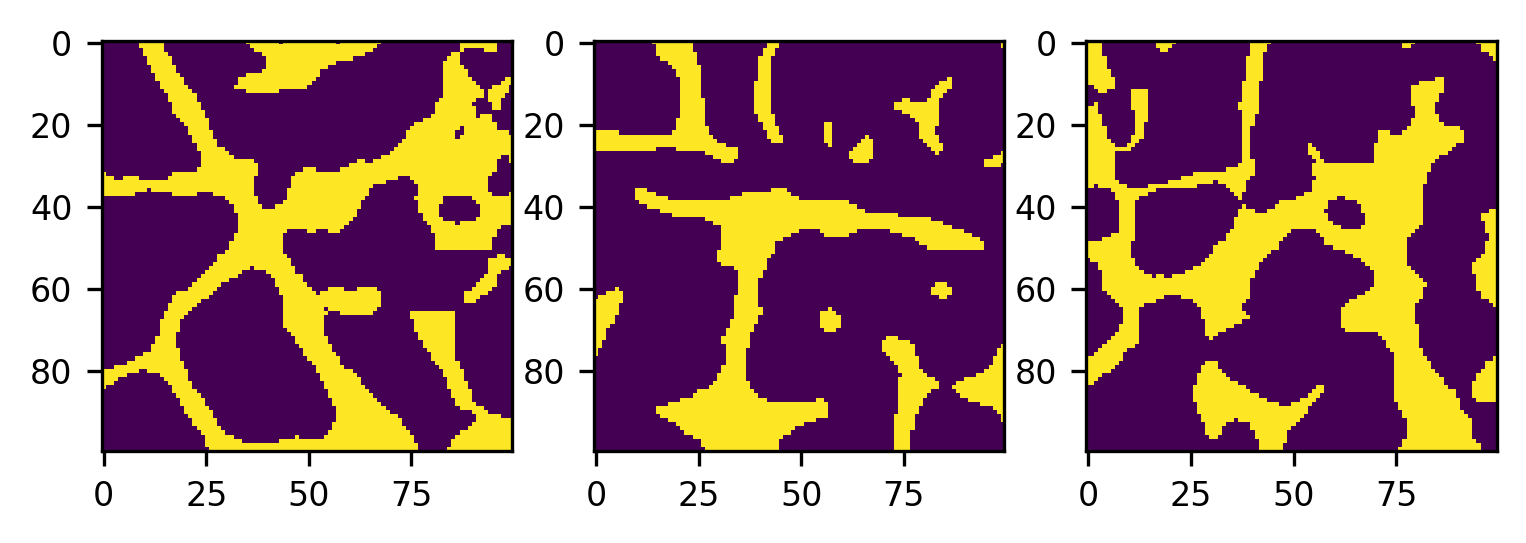

In [13]:
plot_midplanes(BW)
plt.show()

### Detect largest isolated cluster of voxels
The procedure is described by the following 3 steps:
1. Label the BW 3D image

In [23]:
# [labels, n_labels] = measure.label(BW, None, True, 1) # 1 connectivity hop

2. Count the occurrences of each label

In [24]:
# occurrences = np.bincount(labels.reshape(labels.size))

3. Find the largest unconnected label

In [26]:
# largest_label_id = occurrences[1:].argmax()+1
# L = labels == largest_label_id

You can do the same using the function `remove_unconnected` contained in the ciclope module **pybonemorph**

In [14]:
from pybonemorph import remove_unconnected

In [15]:
L = remove_unconnected(BW)

Inspect dataset

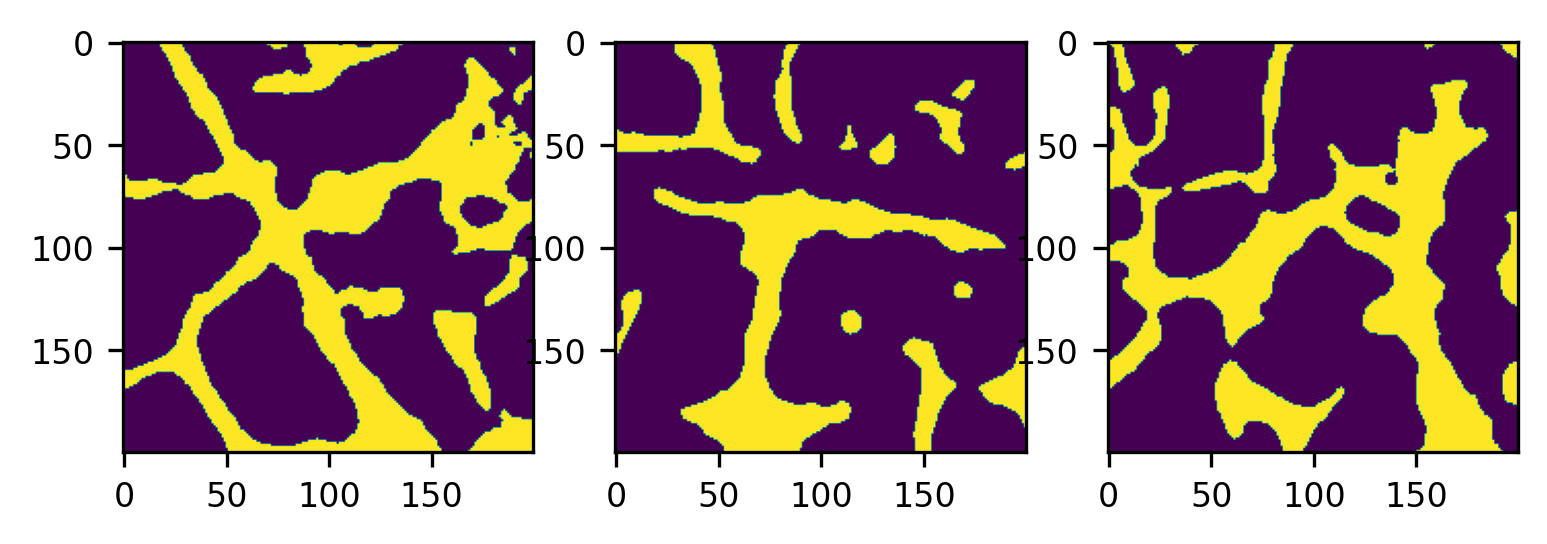

In [15]:
plot_midplanes(L)
plt.show()

## ciclope can generate meshes for visualization
### Create a mesh of triangles of the external bone surface (optional)
Warning: this step is computationally expensive. Only useful for 3D rendering of the bone architecture.
1. Create the shell mesh of triangles

In [17]:
vertices, triangles, mesh = ciclope.tetraFE.shell_mesh(L, method='pymcubes')

2. Write the mesh as a VTK file with [meshio](https://github.com/nschloe/meshio)

In [18]:
filename_shellmesh_out = './../../test_data/LHDL/3155_D_4_bc/3155_D_4_bc_shellmesh.vtk'

In [20]:
import meshio
meshio.write_points_cells(filename_shellmesh_out, vertices.tolist(), [("triangle", triangles.tolist())])

Visualize the mesh with itkwidgtes

In [21]:
import vtk
import itk
from itkwidgets import view

In [22]:
reader = vtk.vtkUnstructuredGridReader()
reader.SetFileName(filename_shellmesh_out)
reader.Update()
grid = reader.GetOutput()

In [23]:
view(geometries=grid)

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

![triangle mesh](LHDL_shellmesh.png)

### Create tetrahedra mesh
Volume meshing using [CGAL](https://www.cgal.org/) through [pygalmesh](https://github.com/nschloe/pygalmesh)

In [25]:
filename_mesh_out = './../../test_data/LHDL/3155_D_4_bc/3155_D_4_bc_tetramesh.vtk'

This is the `pygalmesh` function call

In [ ]:
# import pygalmesh
# mesh = pygalmesh.generate_from_array(np.transpose(L, [2, 1, 0]).astype('uint8'), tuple(vs), max_facet_distance=1.2*min(vs), max_cell_circumradius=5*1.2*min(vs))

Alternatively use the method `ciclope.tetraFE.cgal_mesh`
For some reason this works only from script

In [ ]:
mesh = ciclope.tetraFE.cgal_mesh(L, vs, 'tetra', 1.2*min(vs), 5*1.2*min(vs))

In [96]:
mesh.write(filename_mesh_out)

Visualize the mesh with itkwidgtes

In [10]:
reader = vtk.vtkUnstructuredGridReader()
reader.SetFileName(filename_mesh_out)
reader.Update()
grid = reader.GetOutput()

In [11]:
view(geometries=grid)

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

![tetrahedra mesh](LHDL_tetraFE.png)

## Write Abaqus input FE files
### Generate tetrahedra-FE model with constant material properties
The method `ciclope.tetraFE.mesh2tetrafe` assumes that the material property definition is contained in the FE analysis `.INP` template file.

In [15]:
input_template = "./../../input_templates/tmp_example01_comp_static_bone.inp"

Inspect input template file

In [16]:
!cat {input_template} # on linux
# !type ".\..\..\input_templates\tmp_example01_comp_static_bone.inp # on Win

** ----------------------------------------------------
** Material definition:
*MATERIAL, NAME=BONE
*ELASTIC
18000, 0.3, 0
*SOLID SECTION, ELSET=SET1, MATERIAL=BONE
** ---------------------------------------------------
** Analysis definition. The Step module defines the analysis steps and associated output requests.
** More info at:
** https://abaqus-docs.mit.edu/2017/English/SIMACAECAERefMap/simacae-m-Sim-sb.htm#simacae-m-Sim-sb
** ---------------------------------------------------
*STEP
*STATIC
** All displacements fixed at bottom:
*BOUNDARY
NODES_Z0, 1, 3, 0.0
** Vertical displacement imposed at top:
*BOUNDARY
NODES_Z1, 3, 3, -0.04
** ---------------------------------------------------
** Output request:
*NODE FILE, OUTPUT=2D
U
*NODE PRINT, TOTALS=ONLY, NSET=NODES_Z0
RF
*EL FILE, OUTPUT=2D
S, E
*END STEP


In [17]:
filename_out = './../../test_data/LHDL/3155_D_4_bc/3155_D_4_bc_4_tetraFE.inp'

Generate CalculiX FE input file

In [ ]:
ciclope.tetraFE.mesh2tetrafe(mesh, input_template, filename_out)

## Solve FE model in calculix
The following section assumes that you have the Calculix solver installed and accessible with the command `ccx_2.17` or for multithread option `ccx_2.17_MT`. <br />
The multithread option in CalculiX is activated by defining the number of threads (default=1) used for the calculation.<br />
This is done by setting the env variable *OMP_NUM_THREADS* with:
`export OMP_NUM_THREADS=8`

In [263]:
# !export OMP_NUM_THREADS=8; ccx_2.17_MT "./../../test_data/LHDL/3155_D_4_bc/3155_D_4_bc_tetraFE"

### Convert Calculix output to Paraview
The following sections assume that you have **ccx2paraview** and **Paraview** installed and working.<br /> For more info visit: <br />
https://www.paraview.org/ <br />
https://github.com/calculix/ccx2paraview

In [9]:
import os
import ccx2paraview

In [18]:
filename_out_base, ext_out = os.path.splitext(filename_out)
ccx2paraview.Converter(filename_out_base + '.frd', ['vtk']).run()

#### Visualize results in Paraview

In [65]:
!paraview filename_out_base + '.vtk'

![](./../test_data/steel_foam/B_matrix_tetraFE_Smises.png)

#### Post-process FE analysis results
Display the CalculiX FE output `.DAT` file:

In [13]:
filename_dat = './../../test_data/LHDL/3155_D_4_bc/3155_D_4_bc_4_tetraFE.dat'

In [14]:
!cat {filename_dat}


 total force (fx,fy,fz) for set NODES_Z0 and time  0.1000000E+01

        6.087518E-13  7.423662E-13  2.390246E+02


### Apparent elastic modulus

In [21]:
E = 2.39e2/0.04
print(f"{E:.2f}MPa")

5975.00MPa


Bone volume fraction

In [ ]:
BVTV = 100*np.sum(L)/L.size
print(f"{BVTV:.2f}%")